# Linear Regression

## The Normal Equation

* Let's generate some linear-looking data to test this equation:

In [1]:
import numpy as np
np.random.seed(42) # to make this code example reproducible
m = 100 # number of instances
X = 2 * np.random.rand(m, 1) # column vector
y = 4 + 3 * X + np.random.randn(m, 1) # column vector

*  Now let’s compute θ^ using the Normal equation. We will use the inv() function from NumPy’s linear algebra module (np.linalg) to compute the inverse of a matrix, and the dot() method for matrix multiplication:

In [2]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X) # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

theta_best

array([[4.21509616],
       [2.77011339]])

* Now we can make predictions using θ^:

In [3]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new) # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

* Let's plot this model's predictions:

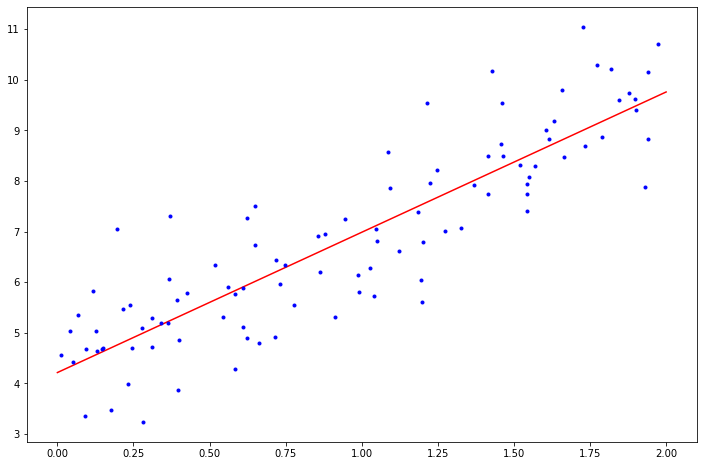

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")
plt.show()

* Performing linear regression using Scikit-Learn is relatively straightforward:

In [5]:
from sklearn.linear_model import LinearRegression
lin_req = LinearRegression()
lin_req.fit(X, y)
lin_req.intercept_, lin_req.coef_

(array([4.21509616]), array([[2.77011339]]))

In [6]:
lin_req.predict(X_new)

array([[4.21509616],
       [9.75532293]])

* Notice that Scikit-Learn separates the bias term (intercept_) from the feature weights (coef_). The LinearRegression class is based on the scipy.linalg.lstsq() function (the name stands for “least squares”), which you could call directly:

In [7]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

* This function computes θ^=X+y, where X+ is the pseudoinverse of X (specifically, the Moore–Penrose inverse). You can use np.linalg.pinv() to compute the pseudoinverse directly:

In [8]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

## Gradient Descent

* Gradient descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of gradient descent is to tweak parameters iteratively in order to minimize a cost function.

### Batch Gradient Descent

* To implement gradient descent, you need to compute the gradient of the cost function with regard to each model parameter θ . In other words, you need to calculate how much the cost function will change if you change θ just a little bit. This is called a partial derivative.

 * Let’s look at a quick implementation of this algorithm:

In [9]:
eta = 0.1 # learning rate
n_epochs = 1000
m = len(X_b) # number of instances

In [10]:
np.random.seed(42)
theta = np.random.randn(2, 1) # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta-y)
    theta = theta - eta * gradients

In [11]:
theta

array([[4.21509616],
       [2.77011339]])

* That’s exactly what the Normal equation found!

### Stochastic Gradient Descent

* This code implements stochastic gradient descent using a simple learning schedule:

In [12]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters


def learning_schedule(t):
    return t0/(t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1) # random initialization

for epoch in range(n_epochs):
    for iteration in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi) #for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients

In [13]:
theta

array([[4.21076011],
       [2.74856079]])

* Perform linear regression using stochastic GD with Scikit-Learn:

In [14]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel()) # y.ravel() because fit() expects 1D targets

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [15]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

# Polynomial Regression

* What if your data is more complex than a straight line? Surprisingly, you can use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called polynomial regression.

In [16]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.rand(m, 1)

* So let’s use Scikit- Learn’s PolynomialFeatures class to transform our training data, adding the square (second-degree polynomial) of each feature in the training set as a new feature (in this case there is just one feature):

In [17]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [18]:
X[0]

array([-0.75275929])

In [19]:
X_poly[0]

array([-0.75275929,  0.56664654])

* X_poly now contains the original feature of X plus the square of this feature. Now we can fit a LinearRegression model to this extended training data

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.49786712]), array([[0.9943591 , 0.49967213]]))

# Learning Curves

* If you perform high-degree polynomial regression, you will likely fit the training data much better than with plain linear regression.
* Let’s use this function to look at the learning curves of the plain linear regression model

In [21]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(),
    X,
    y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

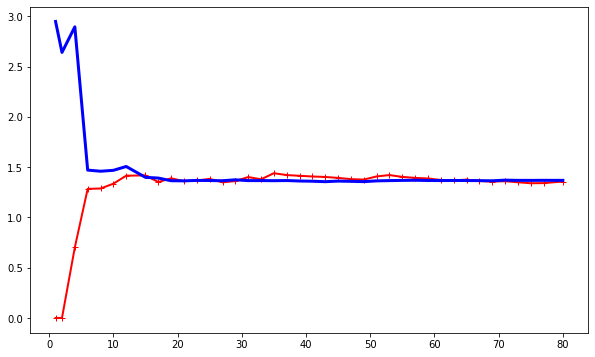

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.show()

* Now let’s look at the learning curves of a 10th-degree polynomial model on the same data

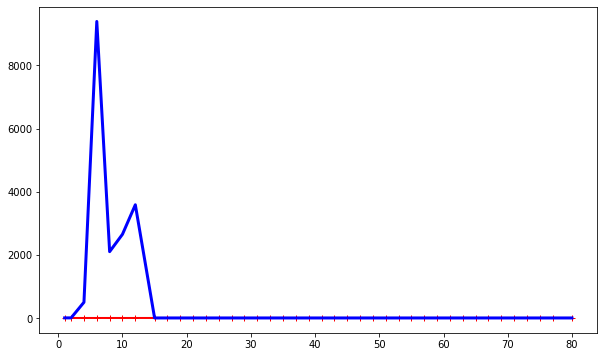

In [23]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression()
)

train_size, train_scores, valid_scores = learning_curve(
    polynomial_regression,
    X,
    y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.show()

# Regularized Linear Models

## Ridge Regression

* This is how to perform ridge regression.

In [24]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.44714236]])

* And using stochastic gradient descent

In [25]:
sgd_reg = SGDRegressor(
    penalty="l2",
    alpha=0.1 / m,
    tol=None,
    max_iter=1000,
    eta0=0.01,
    random_state=42
)
sgd_reg.fit(X, y.ravel()) # It expects 1D targets
sgd_reg.predict([[1.5]])


array([5.44590102])

## Lasso Regression

In [26]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.3944001])

In [27]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l1", alpha=0.1)
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])

c:\Users\MRE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([5.38152146])

## Elastic Net Regression

In [28]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])


array([5.39746654])

## Early Stopping

In [30]:
from copy import deepcopy
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(
    PolynomialFeatures(
        degree=90,
        include_bias=False
    ),
    StandardScaler()
)

X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(
    penalty=None,
    eta0 = 0.002,
    random_state=42
)
n_epochs=500
best_valid_rmse=float('inf')

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = root_mean_squared_error(y_valid, y_valid_predict)
    if (val_error < best_valid_rmse):
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

In [31]:
best_valid_rmse

1.4099344710854795

# Logistic Regression

## Decision Boundaries

* Let's try to build a classifier to detect the Irıs virginica type based only on the petal width feature. The first step is to load the data an take a quick peek.

In [33]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [37]:
iris.data.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [38]:
iris.target.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [41]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

* Let's look at the model's estimated probabilities for flowers with petal widths varying from 0 cm to 3 cm.

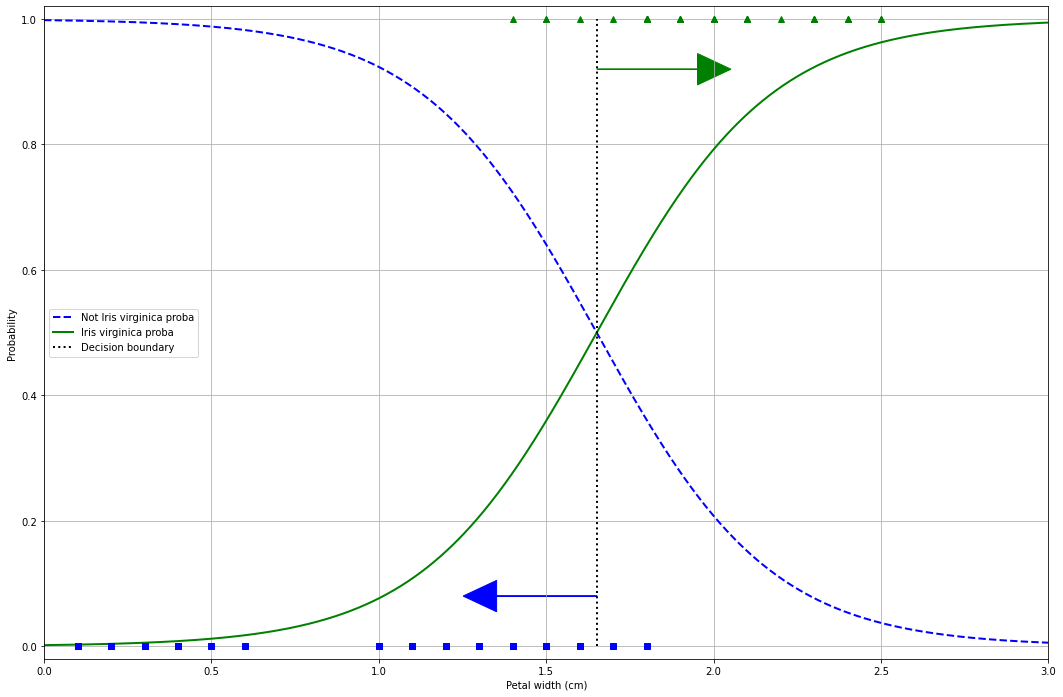

In [48]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1) # reshape o get a column vector
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(18, 12))
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()

plt.show()

In [49]:
# Decision Boundary
decision_boundary

1.6516516516516517

In [50]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

## Softmax Regression

* Let's use softmax regression to classify the iris plants into all three classes.

In [51]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

In [52]:
softmax_reg.predict([[5, 2]])

array([2])

In [53]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])